# Supervised Learning - Classification Problem

## Students' dropout and academic success

### (Droupout, Enrolled, Graduate)

Faculdade: FEUP - Faculdade de Engenharia da Universidade do Porto

Curso: L.EIC - Licenciatura em Engenharia Informática e Computação 

Unidade Curricular: Inteligência Artificial

Ano Curricular: 2021/22

Grupo: 21_1D

Elementos:
- Henrique Ribeiro Nunes, up201906852@up.pt
- Margarida Assis Ferreira, up201905046@up.pt
- Patrícia do Carmo Nunes Oliveira, up201905427@up.pt

### Especificação

O foco principal deste problema é analisar a informação conhecida sobre a matrícula do aluno (percurso acadêmico, demografia e fatores socioeconómicos) e o desempenho académico dos alunos no final do primeiro e segundo semestres. Com o objetivo de usar estes dados para construir modelos de classificação para **prever a desistência e o sucesso académico dos alunos**.

Este problema é um ***single label multiclass classification problem*** com 37 atributos:
- 36 métricas distintas para descrever as informações do aluno.
- 1 objetivo com 3 resultados possíveis (*Droupout*, *Enrolled*, *Graduate*).

Existe um **forte desbalanceamento** em relação a um dos resultados possíveis.


### Tools & Resources

// TODO AQUI 

## Data Analysis

A análise dos dados é um passo importante nos problemas de classificação. 

Nesta secção são analisados os atributos que classificam os dados e o tipo e intervalo de valores de cada um dos atributos, bem como o tamanho do conjunto de dados, a presença de valores nulos ou amostras duplicadas. Igualmente é explorado a distribuição das classes e de valores por atributos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
SAVE_FILE = False

In [ ]:
# Load data
data = pd.read_csv("data/data.csv")
pd.set_option('max_columns', None)

In [ ]:
# Print head values and summary statistics
print(data.describe())
print()
print(data.head())
print()

In [ ]:
# Get all 36 features used and 3 possible results
features = list(data.columns)
features.remove("class")
print("Number of Features: {}".format(len(features)))
print("Features: {}".format(features))
values = list(data[features].values)

classes = list(data["class"].unique())
classes.sort()
print("\nNumber of Results: {}".format(len(classes)))
print("Result/Prediction: {}".format(classes))
targets = list(data["class"].values)

In [ ]:
# Check atribute types and values interval
for name, dtype in data.dtypes.iteritems():
    print("{} | {} | [{} , {}] ".format(name.ljust(46), str(dtype).ljust(7), data[name].min(), data[name].max()))

In [ ]:
# Data size
print("Data Size: {}".format(len(data)))

In [ ]:
# Check if there are columns with N/A values
print("N/A values found: {}".format(data.isnull().values.any()))

In [ ]:
# Check if there are duplicated Data
bool_series = data.duplicated()
print(bool_series)

old_size = len(data)

# Removing all duplicated data if exists
data = data[~bool_series] 

new_size = len(data)

# check if there were actualy duplicated data
print()
if (new_size == old_size):
    print("No data was removed: there were no duplicated data")
else:
    print("Was found and removed {} duplicated data".format(old_size-new_size))

In [ ]:
# Resultant data without duplicated entries
data

In [ ]:
# Histogram for each feture values and respective count of classses

def count_targets_for_each_value(data, feat):
    data_aux = data[[feat, "class"]]
    d = {}
    for line in data_aux.values:
        if not line[0] in d:
            d[line[0]] = {classes[0]: 0, classes[1]: 0, classes[2]: 0}
        d[line[0]][line[1]] += 1

    for entry in d.keys():
        d[entry] = [d[entry][c] for c in classes]
    aux = pd.DataFrame(d, index=classes)
    return aux.reindex(sorted(aux.columns), axis=1)


for i in range(36):
    plt.title(features[i])
    plt.hist(data[features[i]].values)
    plt.show()
    print(count_targets_for_each_value(data, features[i]))

In [ ]:
# Class Distribution
# Check data balance
def countEachClass(data):
    n_graduate = data['class'].value_counts().Graduate
    n_dropouts = data['class'].value_counts().Dropout
    n_enrroled = data['class'].value_counts().Enrolled
    return n_graduate, n_dropouts, n_enrroled
n_graduate, n_dropouts, n_enrroled = countEachClass(data)
print("Number of 'Graduate' occurences: {}".format(n_graduate))
print("Number of 'Dropout' occurences: {}".format(n_dropouts))
print("Number of 'Enrolled' occurences: {}".format(n_enrroled))
print()

# Corresponding plot 
count_result = pd.DataFrame(data["class"]).value_counts().rename_axis("class").reset_index(name="count")
print(count_result)

# Bar plot
plot_count_res = sb.barplot(data=count_result, x="count", y="class")
plt.show()

# Pie plot with percentages
plt.pie([n_graduate, n_dropouts, n_enrroled], autopct = '%0.00f%%')
plt.show()

Analisando a distribuição de cada atributo pelas classes possíveis, podemos concluir que existem alguns atributos irrelevantes, na medida que não se distingue à priori nem se obtem qualquer informação sobre qual a classe mais provável para uma nova amostra com base no valor desse atributo, como conseguimos identifificar no caso do atributo 'Curricular units 2nd sem (credited)'

In [ ]:
# Distribution of each attribute 
def densityPlot(x, hue, fill):
    sb.displot(data, x=x, hue=hue, kind="kde", fill=fill)
    
# all 36 distinct attributes
attributes = list(data.columns)
attributes.remove("class")
    
for attribute in attributes:
    densityPlot(attribute, 'class', True)

**Propriedades do Problema:** (a partir da análise dos dados de entrada)

- Nominal and Discrete attributes (including some binary ones)
- Dimensionality = 37 attibutos
- Size = 4424
- Type = Data Matrix
- No missing or duplicate Data
- No meaningful outliers
- Imbalance data

### Correlation Heatmap 

In [ ]:
plt.imshow(data.drop['class'], cmap='hot', interpolation='nearest')
plt.show()

## Pré-processamento dos dados

Tendo em conta as conclusões obtidas pela a análise dos dados originais mostrada anteriormente, podemos apercebermo-nos que é necessário realizar um pré-processamento dos dados, com o objetivo de resolver o maior problema adjacente a estes: a falta de balanceamento entre as diferentes classes de alvo. 

Para tal podemos usar entre outras estratégias uma das seguintes:
- **oversampling** : «Aumentar o número de amostras/entradas da menor classe até coincidir com o tamanho da maior classe»
- **undersampling** : «Diminuir o número de amostras/entradas da maior classe até coincidir com o tamanho da menor classe»

Em qualquer uma das abordagens acima, a escolha das amostras escolhidas para serem retidas ou replicadas com pequenas modificações é aleatória.

### Standardization

In [60]:
from sklearn.preprocessing import StandardScaler

def standardize(data, to_standardize):
    data_to_standardize = data[to_standardize]
    scaler = StandardScaler()
    stand_values = scaler.fit_transform(data_to_standardize.values)

    stand_values_df = pd.DataFrame(
        stand_values, 
        index=data_to_standardize.index, 
        columns=to_standardize)
    data[to_standardize] = stand_values_df[to_standardize]
    return data

non_binary_features = [feature for feature in features if len(data[feature].unique()) != 2]
data_standard = standardize(data.copy(), non_binary_features)

### Undersampling

Uma das técnicas para lidar com o desbalanceamento de classes em machine lerning é chamado de *undersampling*. Esta técnica de balanceamento consiste em remover algumas observações das classes majoritárias, até que as classes majoritárias e minoritárias sejam equilibradas. A técnica *undersampling* pode ser uma boa escolha quando temos dados desequilibrados, mas uma desvantagem é que removemos informações que podem ser valiosas.

Para remover as observações das classes majoritárias, usamos a função `sample(sequence, k)`, uma função do módulo `Random` de Python, que retorna uma lista de comprimento `k` de itens escolhidos aleatoriamente de `sequence`.

In [ ]:
# Imbalance Original Data
print("Classes count:")
print(data['class'].value_counts())

data['class'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
class_graduate = data[data['class'] == "Graduate"]
class_dropout = data[data['class'] == "Dropout"]
class_enrolled = data[data['class'] == "Enrolled"]

class_dropout_under = class_dropout.sample(n_enrroled, replace=True)
class_graduate_under = class_graduate.sample(n_enrroled, replace=True)

Agora temos os nossos dados balanceados, como é possível observer no gráfico criado pelo código abaixo.

In [ ]:
data_under = pd.concat([class_dropout_under, class_graduate_under, class_enrolled], axis=0)

# plot the count after under-sampeling
print("Classes count after under-sampling:")
print(data_under['class'].value_counts())

data_under['class'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
# Save to file
if SAVE_FILE: data_under.to_csv("data/data_under.csv", index=False)

### Oversampling

// TODO AQUI -> improve description
Segue o seguinte esquema: [incluir imagem significativa]

As entradas da classe menor sáo replicadas até totalizarem o número de amostras da classe maior.

In [ ]:
# Imbalance Original Data
unbalanced_count = data['class'].value_counts()
unbalanced_count.plot.bar()
plt.show()

In [ ]:
# Separate count and samples by the diferent classes
graduate_count, dropout_count, enrolled_count = data['class'].value_counts()

print("GRADUATE: {} | DROPOUT: {} | ENROLLED: {}".format(graduate_count, dropout_count, enrolled_count))

graduate_samples = data[data['class'] == "Graduate"]
dropout_samples = data[data['class'] == "Dropout"]
enrolled_samples = data[data['class'] == "Enrolled"]

#### Random Over-Sampling

«Oversampling can be defined as adding more copies to the minority class.»

**Disvantagens:** pode causar *overfitting* e pobre generalização do conjunto de dados para teste.

In [ ]:
# number of the smallest to the larger ones
dropout_samples_over = dropout_samples.sample(graduate_count, replace=True)
enrolled_samples_over = enrolled_samples.sample(graduate_count, replace=True)

data_over = pd.concat([graduate_samples, dropout_samples_over, enrolled_samples_over], axis=0)

print("Total dintinct classes: \n{}".format(data_over['class'].value_counts()))

rnd_oversampling_count = data_over['class'].value_counts()
rnd_oversampling_count.plot.bar()
plt.show()

In [ ]:
# Save to file
if SAVE_FILE: data_over.to_csv("data/data_over.csv", index=False)

É importante referir que nenhuma das soluções acima é uma solução perfeita, pois a aplicação de undersampling pode inplicar a perda de infromação, da mesma forma que a aplicação de oversampling (sem qualquer modificação das amostras escolhidas aleatóriamente para serem replicadas) pode levar a um posterior overfitting dos modelos gerados a estes novos dados.


#### Combine under and over sampling

Tendo isto em conta a seguinte tentativa tenta encontrar um meio termos entre as soluções anteriores, fazendo as classes em questão convergir para um valor mediano e não para um máximo nem minímo, tentando combater as consequencias sentidas nos dados ao aplicar isoladamente cada uma das estratégias, obtando por alcaçar um meio termo.

In [ ]:
# make the counts meet at the middle point
# in this case the middle point is consider to be the dropout class
graduate_samples_middle = graduate_samples.sample(dropout_count, replace=True)
enrolled_samples_middle = enrolled_samples.sample(dropout_count, replace=True)

data_under_over = pd.concat([graduate_samples_middle, dropout_samples, enrolled_samples_middle], axis=0)

print("Total dintinct classes: \n{}".format(data_under_over['class'].value_counts()))

under_over_count = data_under_over['class'].value_counts()
under_over_count.plot.bar()
plt.show()

In [ ]:
# Save to file
if SAVE_FILE: data_under.to_csv("data/data_under_over.csv", i)

## Learning Algorithms

### Identification of the Target Concept

// TODO AQUI

In [61]:
#data = pd.read_csv('data/data_over.csv')
data = data_standard
values = list(data[list(data.columns[:-1])].values)
targets = list(data['class'].values)

### Validation

#### Train test split

In [ ]:
from sklearn.model_selection import train_test_split
def split_data(data, classes, test_size):
  feat_train, feat_test, target_train, target_test = train_test_split(data, classes, test_size=test_size, shuffle=True)
  return feat_train, feat_test, target_train, target_test

#### Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
def cross_validation(model, features, targets, cv):
    scores = cross_val_score(model, features, targets, cv=cv)
    return scores

#### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def confusion_matrix(target_test, target_predictions):    
    return metrics.confusion_matrix(target_test, target_predictions)

def display_confusion_matrix(cm):
    metrics.ConfusionMatrixDisplay(cm, display_labels=classes).plot()

#### Validate model

In [ ]:
from sklearn import metrics

def precision(cm, i):
    return cm[i][i]/sum(cm[i])

def recall(cm, i):
    cmt = np.copy(cm).transpose()
    return cmt[i][i]/sum(cmt[i])

def validate(model, features, targets):
    test_size = 0.2
    cross_validation_split = 5
    feat_train, feat_test, target_train, target_test = split_data(features, targets, test_size)
    
    model.fit(feat_train, target_train)
    predictions = model.predict(feat_test)
    
    acc = metrics.accuracy_score(target_test, predictions)
    print("Accuracy: {:.2f}\n".format(acc*100))
    
    cm = confusion_matrix(target_test, predictions)
    print("Precision:")
    for i in range(3): print("\t{:.2f}% - {}".format(precision(cm, i)*100, classes[i]))
    print("Recall:")
    for i in range(3): print("\t{:.2f}% - {}".format(recall(cm, i)*100, classes[i]))
    
    display_confusion_matrix(cm)
    
    scores = cross_validation(model, features, targets, cross_validation_split)
    print("Cross validation {}-fold: {}".format(cross_validation_split, [round(x, 3) for x in scores]))
    print("\t{:.2f} accuracy with a standard deviation of {:.2f}".format(scores.mean(), scores.std()))

#### Selection and Parameterization of the learning algorithms to employ

:: At least 3 supervised learning (classification) algorithms should be employed (Decision Trees, Neural Networks, KNN, SVM, …) 

### Algorithms

#### Decision Tree Classifier

Accuracy: 75.37

Precision:
	68.84% - Dropout
	45.27% - Enrolled
	89.66% - Graduate
Recall:
	88.94% - Dropout
	43.79% - Enrolled
	78.85% - Graduate
Cross validation 5-fold: [0.747, 0.75, 0.754, 0.758, 0.748]
	0.75 accuracy with a standard deviation of 0.00


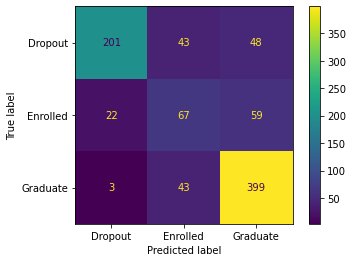

In [62]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
dtc = DecisionTreeClassifier(
  criterion="gini", # criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
  splitter="best", # splitter{“best”, “random”}, default=”best”
  max_depth=5, 
  max_features=20, # max_featuresint, float or {“auto”, “sqrt”, “log2”}, default=None
  max_leaf_nodes=None) # max_leaf_nodes: int, default=None
validate(dtc, values, targets)

In [ ]:
# Plot tree
from sklearn.tree import plot_tree
plot_tree(dtc)

In [ ]:
# Create PDF with the tree
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(dtc, out_file=None, feature_names=labels, class_names=targets ) 
graph = graphviz.Source(dot_data) 
graph.render("decision_tree") 

#### K-nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 3

knc = KNeighborsClassifier(n_neighbors,weights="uniform")
validate(knc, values, targets)

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay
'''
_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X=np.array([line[:2] for line in data_train]),
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
)

sns.scatterplot(
        x=data[labels[0]],
        y=data[labels[1]],
        alpha=1.0,
        edgecolor="black",
    )
plt.show()
'''

#### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

nnc = MLPClassifier(
    solver='lbfgs', 
    alpha=1e-5,
    hidden_layer_sizes=(5, 2),
    max_iter=5000,
    random_state=1)

validate(nnc, values, targets)

#### Evaluation of the learning process

:: compared using appropriate evaluation
metrics (performance during learning, confusion matrix, precision, recall, accuracy, F1 measure) and the time
spent to train/test the models.
(in particular on the test set)

:: compared using the Scikit-Learn Python library and considering
the characteristics of the dataset.

#### Results Comparision

:: Results should be compared using tables or plots (e.g., using Seaborn or
Matplotlib libraries).